In [ ]:
#pip install bstpp

In [ ]:
import bstpp

In [ ]:
#!pip install --upgrade scipy jax jaxlib

In [ ]:
from bstpp.main import LGCP_Model, Hawkes_Model,  Point_Process_Model

In [ ]:
import os

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import geopandas
try:
    import geopandas as gpd
    HAS_GEOPANDAS = True
except ImportError:
    HAS_GEOPANDAS = False

import numpyro
import numpyro.distributions as dist

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.1, so it will not be used.
  warnings.warn(


# **CONFIGURATION**

In [ ]:
SEED = 42
np.random.seed(SEED)

In [ ]:
# --- 1. Load Data ---
EBOLA_CSV = "/content/drive/MyDrive/data1/ebola/ebola_sierraleone_2014_processed.csv"
SIERRA_LEONE_SHP = "/content/drive/MyDrive/data1/ebola/shp/sle_admbnda_adm1_gov_ocha_20231215.shp"


In [ ]:
OUTPUT_DIR = '/content/drive/MyDrive/data1/bstpp_ebola_analysis_results/results'
FIGURE_DIR = '/content/drive/MyDrive/data1/bstpp_ebola_analysis_results/figures'


In [ ]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_DIR, exist_ok=True)

#**DATA LOADING**

In [ ]:
events_df = pd.read_csv(EBOLA_CSV)

In [ ]:
# Clean NaNs
events_df = events_df.dropna()

print(events_df.head())

         X       Y  T
0 -10.5730  8.2789  0
1 -10.5730  8.2789  1
2 -10.5730  8.2789  2
3 -10.5730  8.2789  3
4 -13.2333  8.4833  4


In [ ]:
len(events_df)

2699

In [ ]:
events_df['T'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

#**EDA**

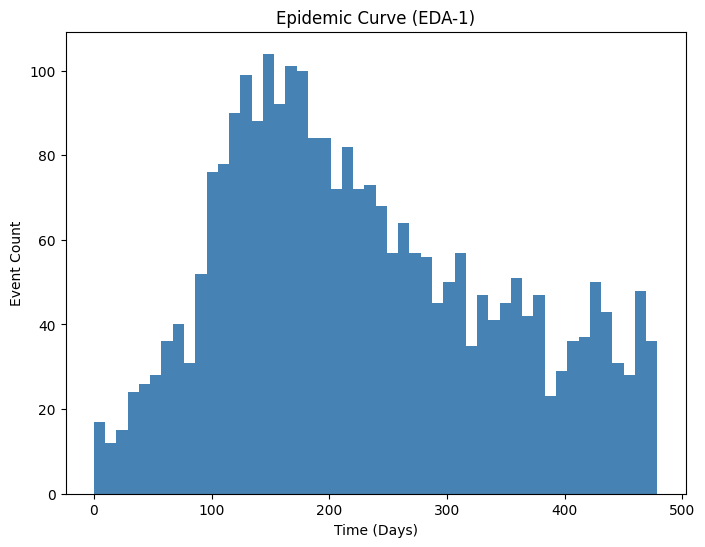

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(events_df['T'], bins=50, color='steelblue')
plt.xlabel("Time (Days)")
plt.ylabel("Event Count")
plt.title("Epidemic Curve (EDA-1)")
plt.savefig(f"{FIGURE_DIR}/EDA-1_epidemic_curve.png")
plt.show()

Text(0.5, 1.0, 'Spatial Event Locations (EDA-2)')

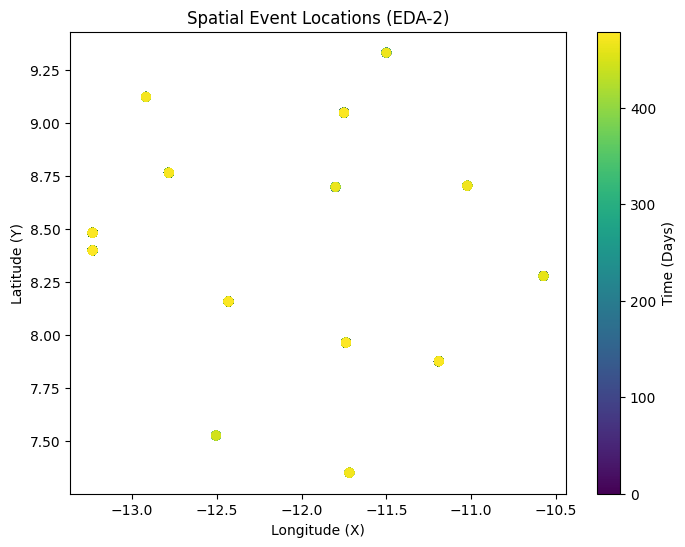

In [ ]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(events_df['X'], events_df['Y'], c=events_df['T'], cmap='viridis')
plt.colorbar(sc, label='Time (Days)')
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")
plt.title("Spatial Event Locations (EDA-2)")

<Figure size 1000x800 with 0 Axes>

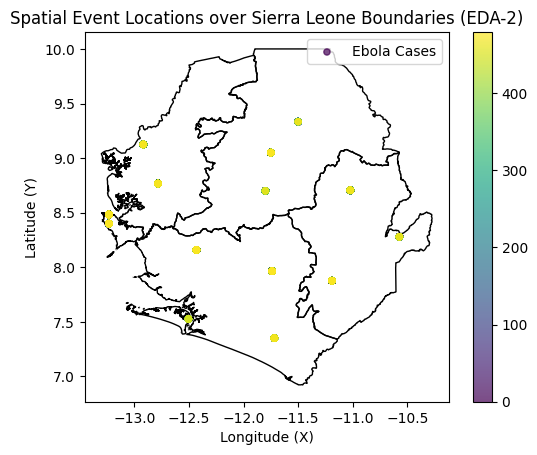

In [ ]:
# =======================
# EDA (Updated to plot shapefile + points together)
# =======================
plt.figure(figsize=(10, 8))

if HAS_GEOPANDAS and SIERRA_LEONE_SHP and os.path.exists(SIERRA_LEONE_SHP):
    boundaries = gpd.read_file(SIERRA_LEONE_SHP)
    ax = boundaries.plot(facecolor="none", edgecolor="black", linewidth=1)
    events_df.plot.scatter(x="X", y="Y", c=events_df["T"], colormap="viridis", ax=ax, alpha=0.7,label='Ebola Cases')
else:
    plt.scatter(events_df['X'], events_df['Y'], c=events_df['T'], cmap='viridis')
    plt.colorbar(label='Time (Days)')
    plt.gca().set_aspect('equal')

plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")
plt.title("Spatial Event Locations over Sierra Leone Boundaries (EDA-2)")
plt.legend()
plt.savefig(f"{FIGURE_DIR}/EDA-2_spatial_scatter.png")
plt.show()


#**DOMAIN DEFINITION**

In [ ]:
x_min, x_max = events_df['X'].min(), events_df['X'].max()
y_min, y_max = events_df['Y'].min(), events_df['Y'].max()

buffer_x = 0.01 * (x_max - x_min)
buffer_y = 0.01 * (y_max - y_min)

grid_bounds = np.array([[x_min - buffer_x, x_max + buffer_x],
                              [y_min - buffer_y, y_max + buffer_y]])

T_max = events_df['T'].max() + 1.0

print("Grid Bounds:", grid_bounds_ebola)
print("T_max:", T_max_ebola)

Grid Bounds: [[-13.259903 -10.546397]
 [  7.330773   9.353127]]
T_max: 480.0


#**Helper Inference Function**

In [ ]:
def run_inference(model, name, method, out_file, rng_key, **kwargs):
    if os.path.exists(out_file):
        try:
            model.load_rslts(out_file)
            print(f"[LOADED] {name} from {out_file}")
            return True
        except:
            pass

    print(f"[RUNNING] {method.upper()} for {name}")

    start = time.time()
    if method == "svi":
        model.run_svi(**kwargs)
    else:
        model.run_mcmc(**kwargs)

    elapsed = time.time() - start
    print(f"[DONE] {name} ({method}) took {elapsed:.2f} seconds")

    model.save_rslts(out_file)

    if method == "svi":
        plt.savefig(f"{FIGURE_DIR}/{name}_svi_loss.png")
        plt.close()

    return True

#**Priors**

In [ ]:
priors = {
    "a_0": dist.Normal(1, 10),
    "alpha": dist.Beta(20, 60),
    "beta": dist.HalfNormal(2.0),
    "sigmax_2": dist.HalfNormal(0.25),
}


In [ ]:
GRID_RESOLUTION = 25
MCMC_WARMUP = 500
MCMC_SAMPLES = 1500
MCMC_CHAINS = 1

#**MODEL FITTING**

In [ ]:
hawkes = Hawkes_Model(events_df, grid_bounds, T_max, **priors)

100%|██████████| 20000/20000 [00:46<00:00, 430.67it/s, init loss: -10858.1729, avg. loss [19001-20000]: -50641.3203]


Sampling Posterior...

SVI elapsed time: 60.29723906517029


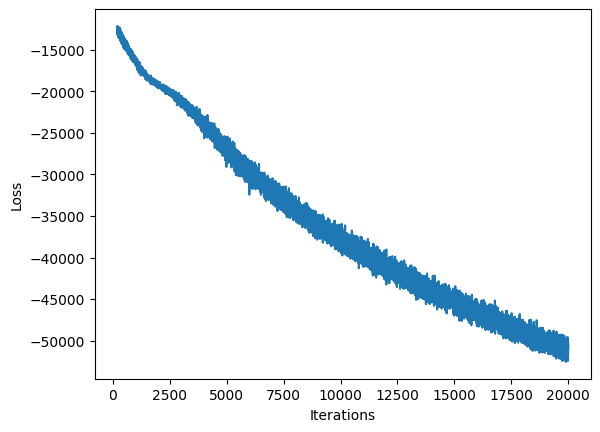

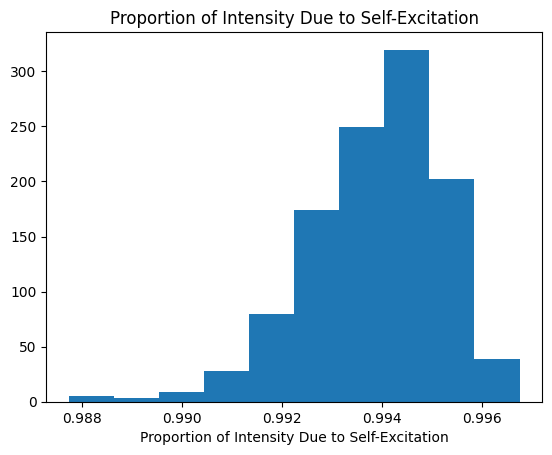

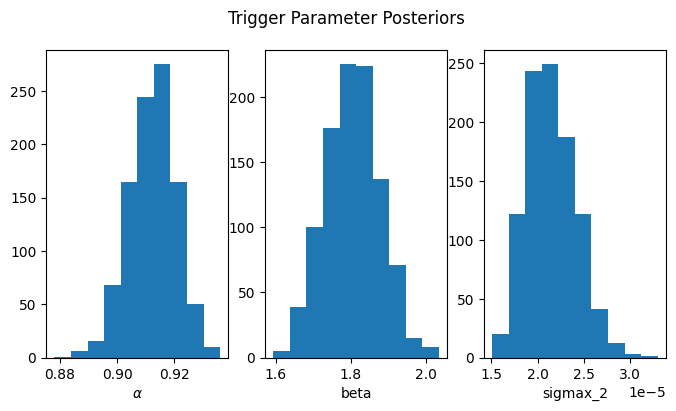

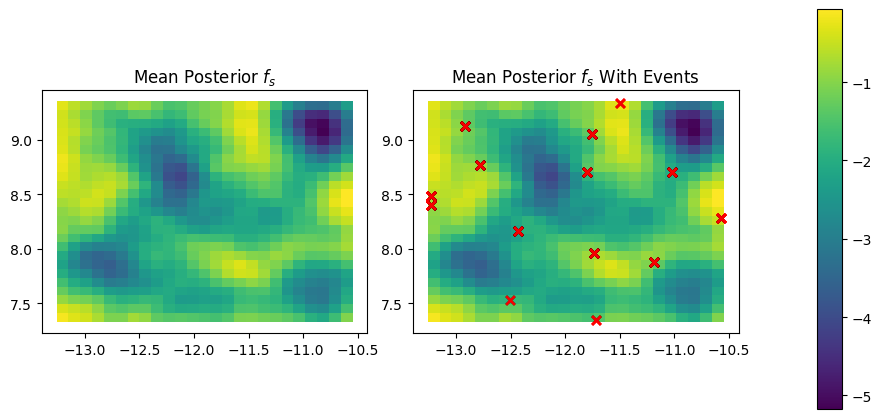

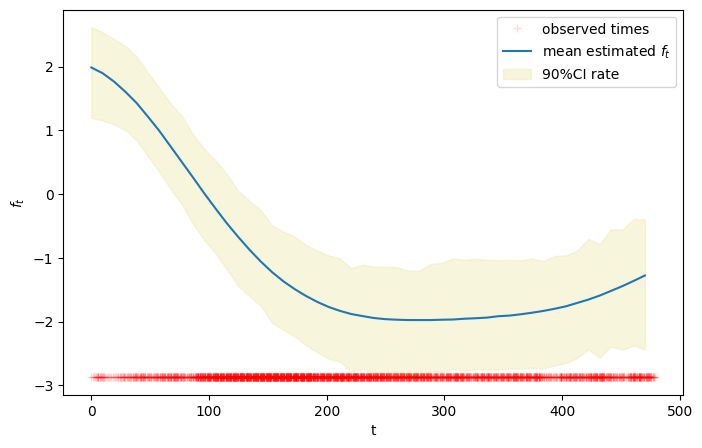

In [ ]:
hawkes.run_svi(num_steps=20000, lr=0.001, plot_loss=True)
hawkes.save_rslts(f"{OUTPUT_DIR}/hawkes_svi.pkl")

hawkes.expected_AIC()

hawkes.plot_prop_excitation()

hawkes.plot_trigger_posterior(trace=False)

hawkes.plot_spatial()

hawkes.plot_temporal()

# LGCP MODEL

In [ ]:

lgcp_cov = LGCP_Model(events_df, grid_bounds, T_max, cov_grid_size=(GRID_RESOLUTION, GRID_RESOLUTION),
                  **priors)

Running LGCP SVI...


100%|██████████| 20000/20000 [00:29<00:00, 671.93it/s, init loss: 1521.4116, avg. loss [19001-20000]: -19064.3242]


Sampling Posterior...

SVI elapsed time: 44.942593574523926


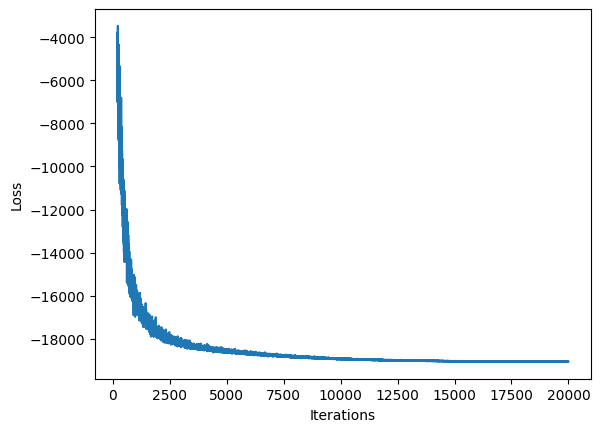

SVI Completed and saved.


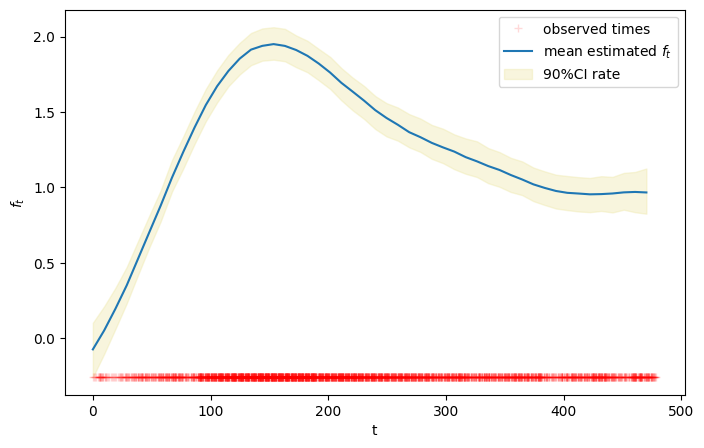

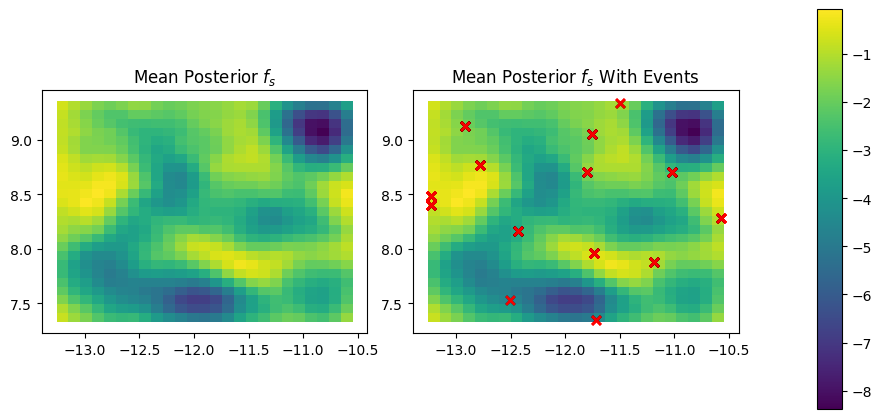

In [ ]:
print("Running LGCP SVI...")

lgcp_cov.run_svi(num_steps=20000, lr=0.001, plot_loss=True)
lgcp_cov.save_rslts(f"{OUTPUT_DIR}/lgcp_cov_svi.pkl")

print("SVI Completed and saved.")

lgcp_cov.expected_AIC()

lgcp_cov.plot_temporal()

lgcp_cov.plot_spatial()




# COX HAWKES MODEL

In [ ]:

coxhawkes_cov = Hawkes_Model(events_df, grid_bounds, T_max, cox_background=True, **priors)

Running Cox-Hawkes SVI...


100%|██████████| 20000/20000 [00:47<00:00, 423.58it/s, init loss: -10858.1729, avg. loss [19001-20000]: -50641.3203]


Sampling Posterior...

SVI elapsed time: 60.73892688751221


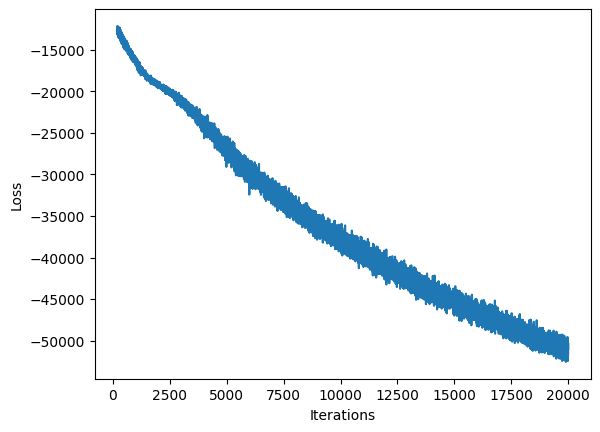

SVI Completed and saved.


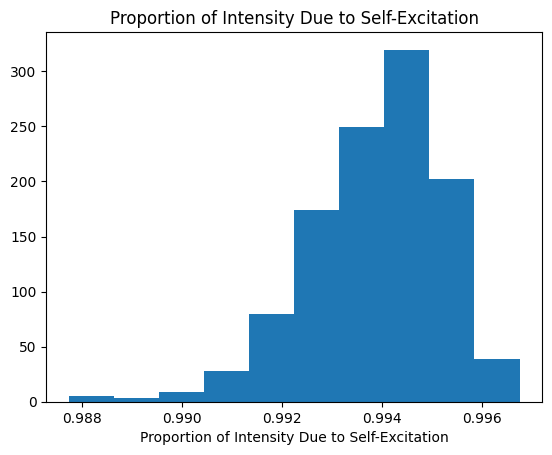

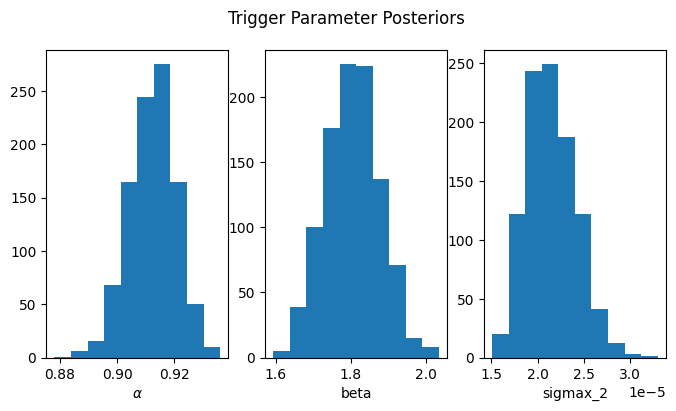

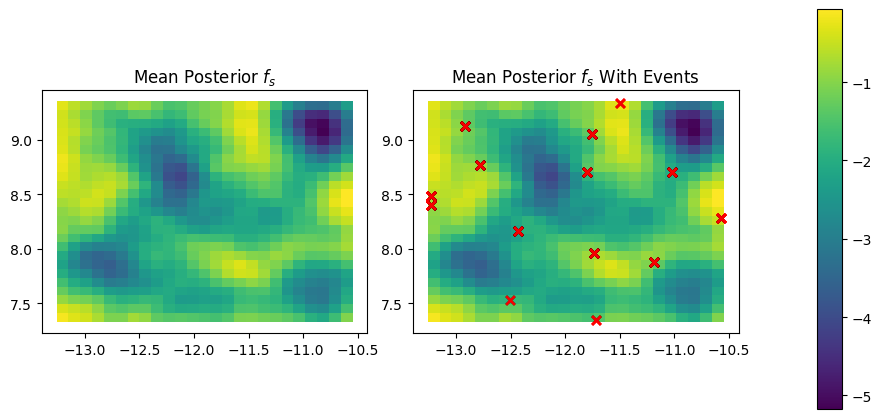

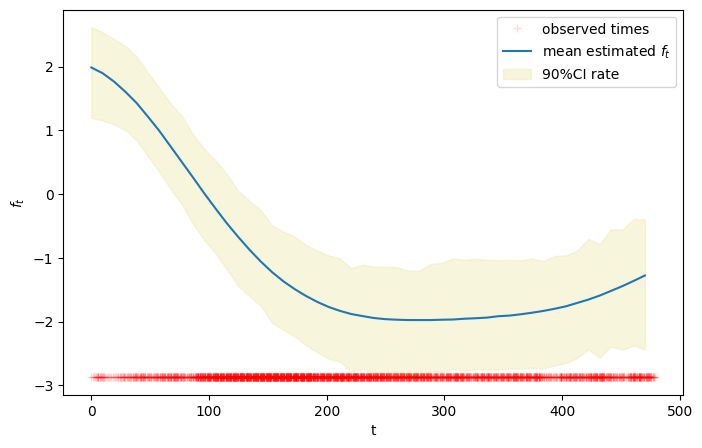

In [ ]:
print("Running Cox-Hawkes SVI...")

coxhawkes_cov.run_svi(num_steps=20000, lr=0.001, plot_loss=True)
coxhawkes_cov.save_rslts(f"{OUTPUT_DIR}/coxhawkes_cov_svi.pkl")

print("SVI Completed and saved.")

coxhawkes_cov.expected_AIC()

coxhawkes_cov.plot_prop_excitation()

coxhawkes_cov.plot_trigger_posterior(trace=False)

coxhawkes_cov.plot_spatial()

coxhawkes_cov.plot_temporal()

